# Testing L96 problem setup
Includes problem setup and testing of algorithms 

By: Rebecca Gjini + Kyle Ivey
09/15/2024

In [1]:
#Import statements
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit, njit
from scipy.linalg import sqrtm
from scipy.optimize import least_squares
import EnsembleMethods as EKA
import l96.L96_model as l96
from cycler import cycler

#Plot preferences from palettable.colorbrewer.qualitative import Set1_9
from palettable.colorbrewer.qualitative import Dark2_8

#Plot Preferences 
plt.rcParams['figure.figsize'] = [11.0, 9.0] #size (w, h)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 400

plt.rcParams['font.size'] = 18 # controls default text sizes
plt.rcParams['legend.fontsize'] = 'large' # legend fontsize
plt.rcParams['figure.titlesize'] = 'large' # fontsize of the figure title  
plt.rcParams['axes.titlesize'] = 18     # fontsize of the axes title
plt.rcParams['axes.labelsize'] = 32   # fontsize of the x and y labels 35
plt.rcParams['xtick.labelsize'] = 20    # fontsize of the tick labels 17
plt.rcParams['ytick.labelsize'] = 20   # fontsize of the tick labels 17
plt.rcParams['axes.spines.right'] = False #makes right line in plot disappear
plt.rcParams['axes.spines.top'] = False #makes top line in plot disappear
plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams['axes.prop_cycle'] = cycler(color=Dark2_8.mpl_colors)

In [6]:
#initialize random seed
np.random.seed(2)

#Creating my sythetic data
#initalize model variables
gamma = 8.0  #forcing constant
nx = 40  #dimensions of parameter vector

t = 0.01  #time step
T_long = 1000  #total time 

#beginning state
int_state = np.random.uniform(0,1,nx)

In [ ]:
#Find the initial condition for my data
spin_up_array = l96.runge_kutta_v(int_state, t, T_long, gamma)
#intital condition used for the data
x0 = spin_up_array[-1]
# np.savetxt('l96/data/x0.txt', x0, delimiter = ',') 
print(x0)

[-0.4640552  -0.46400299  8.52213632 -0.37650577  0.57228566 -2.64426571
  5.56670562  2.30753091 -4.04182181 -1.85505251  9.30282636  1.79212948
 -1.72525487  0.73032027  2.96878859  8.58502128  6.26418014 -2.8422204
  2.65591106  8.25857874  1.43514177 -4.01198229  1.11264213  0.6126342
  4.6826581   3.54836693 -1.49247799  2.71576159  9.26662878 -0.928033
  0.35304236 -0.05410076  2.29866293  7.29239048 -4.47814684 -1.43686238
  0.76386643  2.26573518  6.9634644   0.08079971]


In [ ]:
#Creating my sythetic data
T = 0.2
ny = 20   #number of data points
H = np.zeros((ny, nx))  #creating sampling matrix
for i in range(0, ny): 
    H[i, i + i] = 1
# np.savetxt('l96/data/H.txt', H, delimiter = ',') 

model_out_y = l96.G(x0, t, T, H, gamma)
y = model_out_y  + np.random.normal(0, 1, ny*2) 
print(y)

#Solving for Covariance matrix
covT = 2000  #time to simulate to calculate a covariance matrix of the system
cov_solve = l96.runge_kutta_v(x0, t, covT, gamma)
B = np.cov(cov_solve.T) #Prior covariance matrix
B_sqrt = EKA.matrix_sqrt(B)

R = np.identity(ny*2)  #Data covarinace matrix
R_sqrt_in =  np.identity(ny*2)

mu = np.mean(cov_solve, axis = 0) #Prior mean

#Save problem data, prior, and covarainces 
# np.savetxt('l96/data/y.txt', y, delimiter = ',') 
# np.savetxt('l96/data/R.txt', R, delimiter = ',')
# np.savetxt('l96/data/mu.txt', mu, delimiter = ',')
# np.savetxt('l96/data/B.txt', B, delimiter = ',')


[ 1.93922818  2.91591944  8.09949812  2.00011883 -1.55448357  1.60421428
  7.24080385 -0.16232918 -3.51297817 -4.5089736   3.50409988  4.25070533
 -1.99327297  0.95222954  5.76566204  6.79154103 -4.95966995  0.96985451
 -1.3223901   9.34200327 -1.8746415  -1.21194056  0.97432079  3.37218436
  5.65107577  1.28738042 -3.00557889  2.18418248  8.49639079 -1.38772427
  3.6633457   3.66941568  3.31242527  4.8766225  -4.22421362  3.44713892
  3.63099809  6.30200368  2.25425907 -1.78836554]


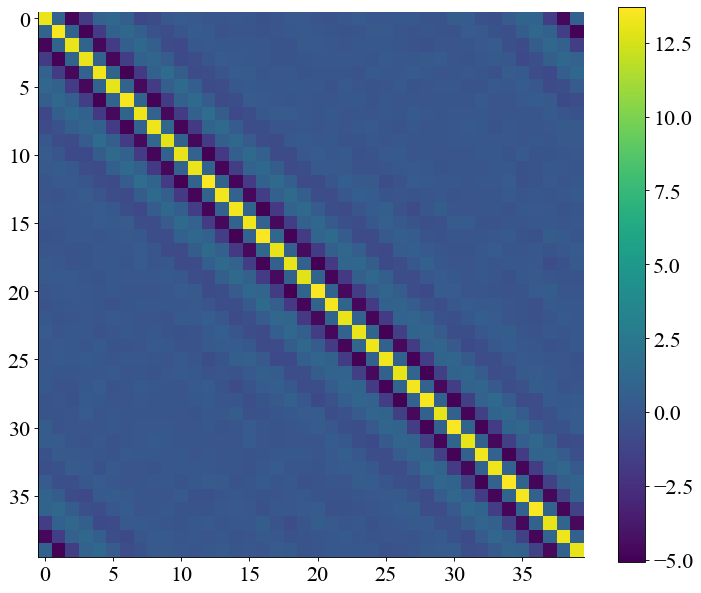

In [9]:
#Plot the prior covariance matrix (which should be the same as Cgg)
plt.figure()
plt.imshow(B)
plt.colorbar()
plt.show()

In [ ]:
#Intitializing EKI ensemble
K = 300        #number of ensemble members

max_runs = 100   #set a maximum number of runs 

N_t = nx         #we only estimate beta and rho


In [16]:
#TEKI Test 
teki_u, teki_f, Cgg, _ = EKA.TEKI(l96.G, K, (t, T, H, gamma), 
                          y, R, mu, B, min_rmse = 0.5, method = 'rmse', 
                             tol_x = 1e-4, tol_f = 1e-4, max_iter = 100)
print(teki_f)
ft = l96.G(np.mean(teki_u, axis = 1), t, T, H, gamma)
np.sqrt((np.linalg.norm(R_sqrt_in@(y - ft))**2)/len(y))

5100


0.49727976361333265

## Notes
- I mostly just copied things from other folders (can't think on the plane atm)
- What I want to do is first check what the covariance structure of y looks like
- Next, we should try to put together the GP process that will be used to alter the covariance matrix
- Then we take samples from the GP and see if it looks similar to the "true" covariance